In [3]:
# crop.py

from facenet_pytorch import MTCNN
from PIL import Image
import torch
from torchvision import transforms

# 1. 얼굴 탐지기 초기화
mtcnn = MTCNN(keep_all=False, device='cpu')  # 단일 얼굴

# 2. 이미지 로딩
image_path = ''
image = Image.open(image_path).convert("RGB")

# 3. 얼굴 탐지 및 crop
face = mtcnn(image)  # (3, H, W) torch.FloatTensor

# 4. 저장 처리
if face is not None:
    # 값을 0~255 범위로 스케일링하고 byte 타입으로 변환
    face = (face * 255).clamp(0, 255).byte()

    # 텐서를 PIL 이미지로 변환 후 저장
    face_pil = transforms.ToPILImage()(face.cpu())
    face_pil.save("cropped_face.jpg")

    print("✅ 얼굴 crop 저장 완료: cropped_face.jpg")
else:
    print("❌ 얼굴을 찾을 수 없습니다.")

ModuleNotFoundError: No module named 'facenet_pytorch'

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise",
    
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # RGB 정규화
])

train_dataset = datasets.ImageFolder('/kaggle/input/rafdataset/RAF dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/rafdataset/RAF dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [3]:
# emotion_swin.py

import torch
import torch.nn as nn
import timm  # pip install timm

class EmotionSwin(nn.Module):
    def __init__(self, num_classes=7, model_name='swin_tiny_patch4_window7_224'):
        super(EmotionSwin, self).__init__()

        # Swin Transformer 전체 모델 불러오기 (분류용 head 포함)
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)  # 출력 shape: [B, num_classes]

[Epoch 1]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 28.33%
✅ Epoch [1/30] | Loss: 1.7805 | Acc: 28.33% | LR: 0.000300


[Epoch 2]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 28.89%
✅ Epoch [2/30] | Loss: 1.7481 | Acc: 28.89% | LR: 0.000271


[Epoch 3]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 28.92%
✅ Epoch [3/30] | Loss: 1.7414 | Acc: 28.92% | LR: 0.000197


[Epoch 4]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 29.64%
✅ Epoch [4/30] | Loss: 1.7273 | Acc: 29.64% | LR: 0.000104


[Epoch 5]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 31.67%
✅ Epoch [5/30] | Loss: 1.6953 | Acc: 31.67% | LR: 0.000030


[Epoch 6]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


✅ Epoch [6/30] | Loss: 1.7193 | Acc: 30.68% | LR: 0.000300


[Epoch 7]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 35.78%
✅ Epoch [7/30] | Loss: 1.6261 | Acc: 35.78% | LR: 0.000293


[Epoch 8]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 47.43%
✅ Epoch [8/30] | Loss: 1.3697 | Acc: 47.43% | LR: 0.000271


[Epoch 9]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 54.86%
✅ Epoch [9/30] | Loss: 1.1884 | Acc: 54.86% | LR: 0.000238


[Epoch 10]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 59.43%
✅ Epoch [10/30] | Loss: 1.0704 | Acc: 59.43% | LR: 0.000197


[Epoch 11]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 63.14%
✅ Epoch [11/30] | Loss: 0.9733 | Acc: 63.14% | LR: 0.000150


[Epoch 12]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 66.72%
✅ Epoch [12/30] | Loss: 0.8828 | Acc: 66.72% | LR: 0.000104


[Epoch 13]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 70.42%
✅ Epoch [13/30] | Loss: 0.7929 | Acc: 70.42% | LR: 0.000063


[Epoch 14]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 73.11%
✅ Epoch [14/30] | Loss: 0.7161 | Acc: 73.11% | LR: 0.000030


[Epoch 15]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 75.38%
✅ Epoch [15/30] | Loss: 0.6613 | Acc: 75.38% | LR: 0.000008


[Epoch 16]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


✅ Epoch [16/30] | Loss: 0.9010 | Acc: 66.20% | LR: 0.000300


[Epoch 17]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


✅ Epoch [17/30] | Loss: 0.8822 | Acc: 66.67% | LR: 0.000298


[Epoch 18]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


✅ Epoch [18/30] | Loss: 0.8520 | Acc: 68.07% | LR: 0.000293


[Epoch 19]: 100%|██████████| 1284/1284 [05:15<00:00,  4.06it/s]


✅ Epoch [19/30] | Loss: 0.8115 | Acc: 69.65% | LR: 0.000284


[Epoch 20]: 100%|██████████| 1284/1284 [05:16<00:00,  4.06it/s]


✅ Epoch [20/30] | Loss: 0.7602 | Acc: 71.47% | LR: 0.000271


[Epoch 21]: 100%|██████████| 1284/1284 [05:16<00:00,  4.06it/s]


✅ Epoch [21/30] | Loss: 0.7022 | Acc: 73.92% | LR: 0.000256


[Epoch 22]: 100%|██████████| 1284/1284 [05:16<00:00,  4.06it/s]


💾 새 최고 정확도! 모델 저장됨: 76.36%
✅ Epoch [22/30] | Loss: 0.6412 | Acc: 76.36% | LR: 0.000238


[Epoch 23]: 100%|██████████| 1284/1284 [05:16<00:00,  4.06it/s]


💾 새 최고 정확도! 모델 저장됨: 78.89%
✅ Epoch [23/30] | Loss: 0.5715 | Acc: 78.89% | LR: 0.000218


[Epoch 24]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 81.65%
✅ Epoch [24/30] | Loss: 0.4991 | Acc: 81.65% | LR: 0.000197


[Epoch 25]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 84.40%
✅ Epoch [25/30] | Loss: 0.4237 | Acc: 84.40% | LR: 0.000174


[Epoch 26]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 87.45%
✅ Epoch [26/30] | Loss: 0.3461 | Acc: 87.45% | LR: 0.000150


[Epoch 27]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 90.14%
✅ Epoch [27/30] | Loss: 0.2750 | Acc: 90.14% | LR: 0.000127


[Epoch 28]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 92.23%
✅ Epoch [28/30] | Loss: 0.2229 | Acc: 92.23% | LR: 0.000104


[Epoch 29]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 94.01%
✅ Epoch [29/30] | Loss: 0.1746 | Acc: 94.01% | LR: 0.000083


[Epoch 30]: 100%|██████████| 1284/1284 [05:15<00:00,  4.07it/s]


💾 새 최고 정확도! 모델 저장됨: 95.26%
✅ Epoch [30/30] | Loss: 0.1390 | Acc: 95.26% | LR: 0.000063
📦 모델 저장 완료: emotion_swin_last.pth


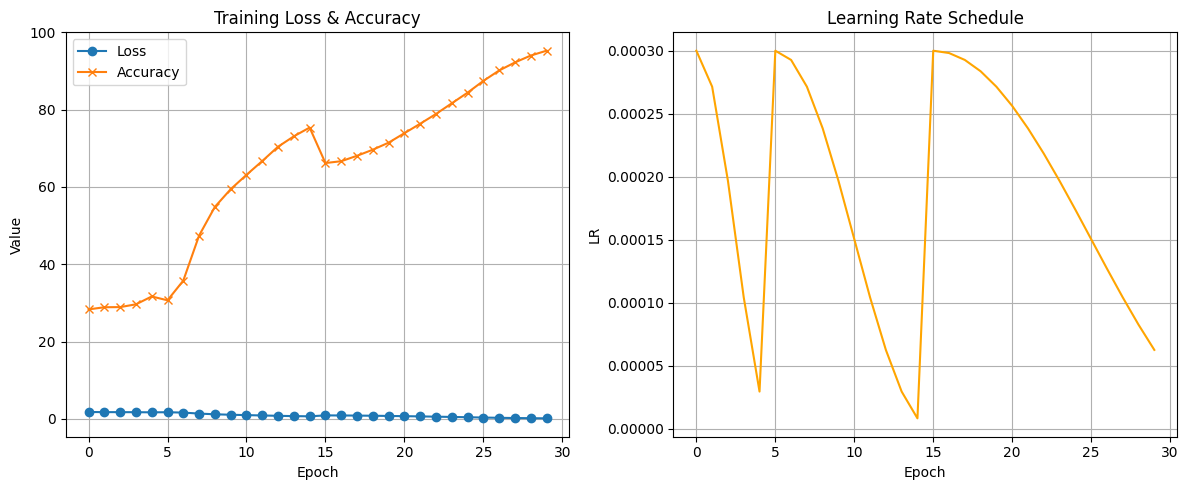

In [ ]:
# train_swin.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts  
import matplotlib.pyplot as plt
from tqdm import tqdm

# 하이퍼파라미터
num_epochs = 30
batch_size = 32
learning_rate = 3e-4
num_classes = 7


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = EmotionSwin(num_classes=num_classes).to(device)

# 손실 함수, 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

loss_history = []
acc_history = []
lr_history = []

best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    lr_history.append(scheduler.get_last_lr()[0])

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"새 최고 정확도! 모델 저장됨: {best_acc:.2f}%")


    print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | LR: {lr_history[-1]:.6f}")

    scheduler.step()

torch.save(model.state_dict(), 'emotion_swin_last.pth')
print("📦 모델 저장 완료: emotion_swin_last.pth")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss', marker='o')
plt.plot(acc_history, label='Accuracy', marker='x')
plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lr_history, label='Learning Rate', color='orange')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.grid(True)

plt.tight_layout()
plt.savefig("swin_train_curve.png")
plt.show()

In [ ]:
# test.py
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionSwin(num_classes=7).to(device)
model.load_state_dict(torch.load('emotion_swin_last.pth', map_location=device))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100. * correct / total
print(f"✅ 테스트 정확도: {accuracy:.2f}%")